# Лабораторная работа 2.
# Решение краевых задач. Методы коллокации, наименьших квадратов и Галеркина (numpy version).

In [58]:
import numpy as np
import math 
import pylab
import scipy

def get_basis_function(n):
    if not n:
        return lambda x: 0
    return lambda x: x ** (n - 1)  * (1 - x ** 2) 

def get_basis_system(num_of_basis_functions):
    return [get_basis_function(n) for n in range(num_of_basis_functions)]

def get_list_of_unknown_coefficients(num):
    return [sp.Symbol('a' + str(n)) for n in range(1, num + 1)]

def numerical_diff(f, x, n):
    h = 0.001
    if not n:
        return f(x)
    elif n == 1:
        return (f(x + h) - f(x - h)) / (2 * h)
    elif n == 2:
        return (f(x - h) - 2 * f(x) + f(x + h)) / (h ** 2)
    else:
        raise NotImplementedError
        
def numerical_integration(f, a, b):
    n = 100
    xlist = np.linspace(a, b, n)
    dx = (b - a) / n
    return sum([f((xlist[i - 1] + xlist[i]) / 2) * dx for i in range(1, n)])
        
def show_plots(functions, start_x, end_x, dx):
    for function in functions:
        dx = 0.01
        xlist = np.arange(start_x, end_x, dx)
        ylist = [function(p) for p in xlist]
        pylab.plot (xlist, ylist)
    pylab.grid(True)
    pylab.show()

### Ищем приближенное решение в виде 
$
y_n(x) = \phi_0(x) + \sum_{i=0}^N \phi_i(x) * a_i
$
, где 
$\phi_i$ - базисная система, $a_i$ - неизвестные коэффициенты

### Рассматриваем невязку:
$\psi(x_1, a_1, ..., a_n) = p(x)y_n''(x) + q(x)y_n'(x) + r(x)y_n(x) - f(x)$


#### Все способы решения задачи сводятся к решению СЛАУ относительно коэффициентов $a_i$

# Метод коллокации

$$
\begin{cases} \psi(x_1, a_1, ..., a_n) = 0, \\ ... \\ \psi(x_n, a_1, ..., a_n) = 0.\end{cases}
$$

## Коэффициеты в матрице:

$$
p(x) * \phi_i''(x_i) + q(x) * \phi_i'(x_i) + r(x) * \phi_i(x_i)
$$




## Вектор свободных членов:

$$
b_i = f(x) - (p(x) * \phi_0''(x_i) + q(x) * \phi_0'(x_i) + r(x) * \phi_0(x_i))
$$

In [2]:
def solve_boundary_task_with_collocation_method(coefficients, f,
                                                collocation_points):
    num_of_basis_functions = len(collocation_points) + 1
    basis = get_basis_system(num_of_basis_functions)
    
    def resudial_part_diff(a):
        return lambda x: sum(coefficients[i](x) * numerical_diff(basis[a], x, i)
                             for i in range(len(coefficients)))
    
    matrix = [[resudial_part_diff(i)(point) for i in range(1, num_of_basis_functions)]
              for point in collocation_points]
    right_side = [f(point) - resudial_part_diff(0)(point)
                  for point in collocation_points]
    answer = np.linalg.solve(np.matrix(matrix), np.array(right_side))
    return lambda x: basis[0](x) + sum(answer[i - 1] * basis[i](x) 
                                       for i in range(1, num_of_basis_functions))

# Интегральный МНК

$$
I = \int_a^b \psi^2(x, a_1, ..., a_n)dx
$$

$$
\begin{cases} \frac{\partial I}{\partial a_1} = 0,\\ ... \\ \frac{\partial I}{\partial a_n} = 0. \end{cases}
$$

## Коэффициеты в матрице:

$$
\int_a^b \frac{\partial \psi}{\partial a_j} \frac{\partial \psi}{\partial a_i} dx
$$


## Вектор свободных членов:

$$
b_i = \int_a^b (f(x) - \frac{\partial \psi}{\partial a_0}) \frac{\partial \psi}{\partial a_i} dx
$$

In [43]:
def solve_boundary_task_with_integral_LSM(coefficients, f, num_of_basis_functions, a, b):
    basis = get_basis_system(num_of_basis_functions)
    def resudial_part_diff(a):
        return lambda x: sum(coefficients[i](x)*numerical_diff(basis[a], x, i)
                             for i in range(len(coefficients)))
    part_diffs = [resudial_part_diff(i) for i in range(num_of_basis_functions)]
    
    matrix = [[numerical_integration(lambda x: part_diffs[i](x) * part_diffs[j](x), a, b)
               for j in range(1, num_of_basis_functions)]
               for i in range(1, num_of_basis_functions)]
    right_side = [numerical_integration(
                  lambda x: (f(x) - part_diffs[0](x)) * part_diffs[i](x), a, b)
                  for i in range(1, num_of_basis_functions)]
    answer = np.linalg.solve(np.matrix(matrix), np.array(right_side))
    return lambda x: basis[0](x) + sum(answer[i - 1] * basis[i](x)
                                       for i in range(1, num_of_basis_functions))

# Дискретный МНК

$$
S = \sum_{i=0}^N \psi^2(x_i, a_1, ..., a_n)
$$

$$
\begin{cases} \frac{\partial S}{\partial a_1} = 0,\\ ... \\ \frac{\partial S}{\partial a_n} = 0. \end{cases}
$$

## Коэффициеты в матрице:

$$
\sum_{k=0}^N \frac{\partial \psi(x_k, ...)}{\partial a_j} \frac{\partial \psi(x_k, ...)}{\partial a_i}
$$


## Вектор свободных членов:

$$
b_i = \sum_{k=0}^N (f(x) - \frac{\partial \psi(x_k, ...)}{\partial a_0}) \frac{\partial \psi(x_k, ...)}{\partial a_i} dx
$$

In [4]:
import time
def solve_boundary_task_with_discrete_LSM(coefficients, f, num_of_basis_functions, points):
    basis = get_basis_system(num_of_basis_functions)
    def resudial_part_diff(a, x):
        return sum(coefficients[i](x) * numerical_diff(basis[a], x, i)
                   for i in range(len(coefficients)))
    part_diffs_x = {(i, x) : resudial_part_diff(i, x) for i in range(num_of_basis_functions) 
                                                      for x in points}
    
    matrix = [[sum(part_diffs_x[(i, x)] * part_diffs_x[(j, x)] for x in points)
               for j in range(1, num_of_basis_functions)]
               for i in range(1, num_of_basis_functions)]
    right_side = [sum([(f(x) - part_diffs_x[(0, x)]) * part_diffs_x[(i, x)] for x in points])
                  for i in range(1, num_of_basis_functions)]
    answer = np.linalg.solve(np.matrix(matrix), np.array(right_side))
    return lambda x: basis[0](x) + sum(answer[i - 1] * basis[i](x) 
                                       for i in range(1, num_of_basis_functions))

# Метод Галеркина

$$
\begin{cases} \int_a^b \psi(x, a_1, ..., a_n)\phi_1(x)dx = 0, \\ ... \\
\int_a^b \psi(x, a_1, ..., a_n)\phi_n(x)dx = 0.\end{cases}
$$

## Коэффициеты в матрице:

$$
\int_a^b \frac{\partial \psi}{\partial a_j} {\phi_i(x)} dx
$$


## Вектор свободных членов:

$$
b_i = \int_a^b (f(x) - \frac{\partial \psi}{\partial a_0}) {\phi_i(x)} dx
$$

In [44]:
def solve_boundary_task_with_Galerkin_method(coefficients, f, num_of_basis_functions, a, b):
    basis = get_basis_system(num_of_basis_functions)
    def resudial_part_diff(a):
        return lambda x: sum(coefficients[i](x) * numerical_diff(basis[a], x, i)
                             for i in range(len(coefficients)))
    part_diffs = [resudial_part_diff(i) for i in range(num_of_basis_functions)]
    
    matrix = [[numerical_integration(lambda x: part_diffs[j](x) * basis[i](x), a, b)
               for j in range(1, num_of_basis_functions)]
               for i in range(1, num_of_basis_functions)]
    right_side = [numerical_integration(
                  lambda x: (f(x) - part_diffs[0](x)) * basis[i](x), a, b) 
                  for i in range(1, num_of_basis_functions)]
    answer = np.linalg.solve(np.matrix(matrix), np.array(right_side))
    return lambda x: basis[0](x) + sum(answer[i - 1] * basis[i](x)
                                       for i in range(1, num_of_basis_functions))

$$ 1) y'' + (1 + x^2) * y = -1; $$
$$ -1 <= x <= 1; $$
$$ y(-1) = y(1) = 0; $$

138 ms ± 4.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


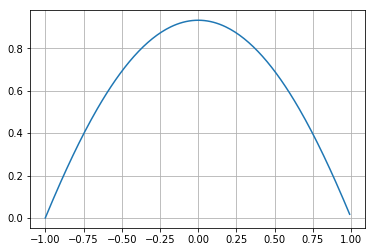

In [45]:
coeffs = [lambda x: 1 + x ** 2,
          lambda x: 0,
          lambda x: 1]
f = lambda x: -1

a = -1
b = 1

collocation_points = np.linspace(a, b, 100)

%timeit answer_1_with_collocation_method = \
    solve_boundary_task_with_collocation_method(coeffs, f, collocation_points)
show_plots([answer_1_with_collocation_method], a, b, 0.01)

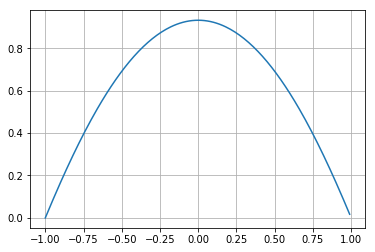

In [59]:
answer_1_with_integral_LSM_method = \
    solve_boundary_task_with_integral_LSM(coeffs, f, 50, a, b)
show_plots([answer_1_with_integral_LSM_method], a, b, 0.01)

1.05 s ± 47.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


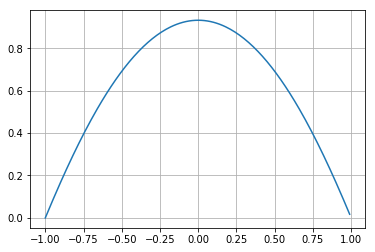

In [48]:
points = np.linspace(a, b, 120)
%timeit answer_1_with_discrete_LSM_method = \
    solve_boundary_task_with_discrete_LSM(coeffs, f, 100, points)
show_plots([answer_1_with_discrete_LSM_method], a, b, 0.01)

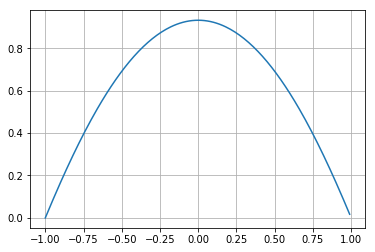

In [60]:
answer_1_with_Galerkin_method = \
    solve_boundary_task_with_Galerkin_method(coeffs, f, 50, a, b)
show_plots([answer_1_with_Galerkin_method], a, b, 0.01)

In [61]:
first_answer = [answer_1_with_collocation_method,
                answer_1_with_integral_LSM_method,
                answer_1_with_discrete_LSM_method,
                answer_1_with_Galerkin_method]

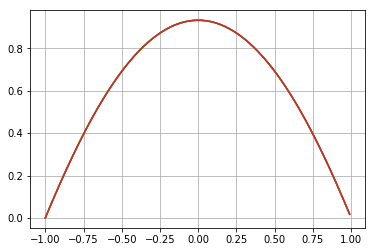

In [62]:
show_plots(first_answer, -1, 1, 0.001)

$$ 2) sin(1) * y'' + (1 + cos(1) * x^2) * y = -1;  $$
$$-1 <= x <= 1; $$
$$ y(-1) = y(1) = 0; $$

162 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


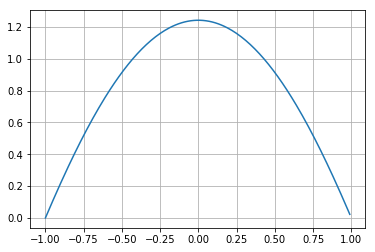

In [63]:
coeffs = [lambda x: 1 + math.cos(1) * x ** 2,
          lambda x: 0,
          lambda x: math.sin(1)]

collocation_points = np.linspace(a, b, 100)

%timeit answer_2_with_collocation_method = \
    solve_boundary_task_with_collocation_method(coeffs, f, collocation_points)
show_plots([answer_2_with_collocation_method], a, b, 0.01)

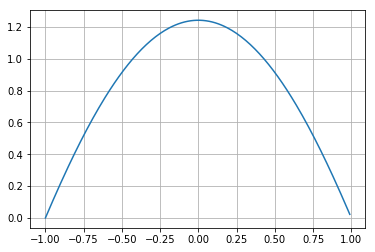

In [64]:
answer_2_with_integral_LSM_method = \
    solve_boundary_task_with_integral_LSM(coeffs, f, 50, a, b)
show_plots([answer_2_with_integral_LSM_method], a, b, 0.01)

1.07 s ± 58.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


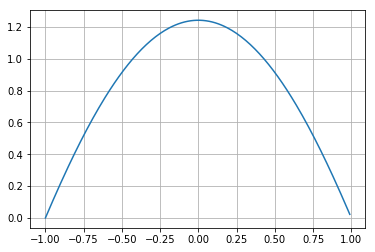

In [67]:
points = np.linspace(a, b, 120)
%timeit answer_2_with_discrete_LSM_method = \
    solve_boundary_task_with_discrete_LSM(coeffs, f, 100, points)
show_plots([answer_2_with_discrete_LSM_method], a, b, 0.01)

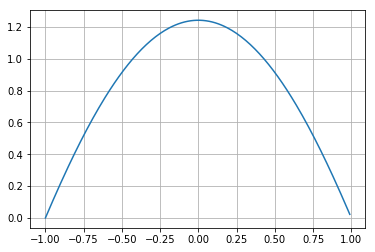

In [68]:
answer_2_with_Galerkin_method = \
    solve_boundary_task_with_Galerkin_method(coeffs, f, 50, a, b)
show_plots([answer_2_with_Galerkin_method], a, b, 0.01)

In [69]:
second_answer = [answer_2_with_collocation_method,
                 answer_2_with_integral_LSM_method,
                 answer_2_with_discrete_LSM_method,
                 answer_2_with_Galerkin_method]

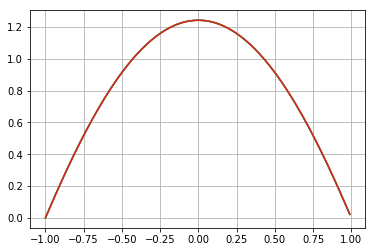

In [70]:
show_plots(second_answer, -1, 1, 0.001)